## 8.2 어텐션을 갖춘 seq2seq 구현

- Attentiond을 갖춘 seq2seq를 구현해 본다.

#### 8.2.1 Encoder 구현
- Encoder는 큰변화가 없다.
- 기존에는 마지막 hidden state만 반환 했지만, Attention Encoder는 모든 hidden state를 모아서 반환한다.

In [3]:
import sys
sys.path.append('..')
from common.time_layers import *
from CH7.seq2seq import Encoder, Seq2seq
from attention_layer import TimeAttention

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs) # lstm의 output은 모든 hs를 반환한다.
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

#### 8.2.2 Decoder 구현

<img width="580" alt="fig 8-21" src="https://github.com/choibigo/Study/assets/38881179/dc60effb-6f46-4ffd-ad5e-32c5ae275feb">


In [9]:
import numpy as np
from numpy.random import randn as rn

from attention_layer import TimeAttention
from common.time_layers import TimeEmbedding, TimeLSTM, TimeAffine

class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention() # attention 계층 추가
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs) # encoder의 output과 lstm의 output을 입력으로 attention
        out = np.concatenate((c, dec_hs), axis=2) # attention의 output과 lstm의 output을 concat하여 Affin계층 입력
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

#### 8.2.3 seq2seq 구현

In [10]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 8.3 어텐션 평가

#### 8.3.1 날짜 형식 변환 문제

<img width="444" alt="fig 8-22" src="https://github.com/choibigo/Study/assets/38881179/dbcd41e5-32c4-4a78-8627-330727ce8585">

- 입력되는 날짜 데이터에는 다양한 변형이 존재하여 변환 규칙이 복잡하다.
- 입력과 출력 사이에 알기 쉬운 대응 관계가 있다.

```
september 27, 1994           _1994-09-27
August 19, 2003              _2003-08-19
2/10/93                      _1993-02-10
10/31/90                     _1990-10-31
TUESDAY, SEPTEMBER 25, 1984  _1984-09-25
...
Sep 30, 1981                 _1981-09-30
June 19, 1977                _1977-06-19
OCTOBER 22, 2005             _2005-10-22
December 1, 2013             _2013-12-01
Wednesday, February 26, 1997 _1997-02-26
```
- 데이터의 입력 문장길이를 공백으로 패딩 해뒀다.
- 입력과 출력을 구분하기 위해 '_'을 사용한다.
- 출력의 수가 일정하기 때문에 끝을 알리는 구분 문자는 사용하지 않는다.

#### 8.3.2 어텐션을 갖춘 seq2seq의 학습
- 

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 5[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 10[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 14[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 19[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 24[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 29[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 34[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 39[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 44[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 49[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 54[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 58[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 63[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 68[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 73[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 78[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 82[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, November 22, 2016  

d:\workspace\Program\anaconda3\envs\python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\workspace\Program\anaconda3\envs\python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\workspace\Program\anaconda3\envs\python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\workspace\Program\anaconda3\envs\python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\workspace\Program\anaconda3\envs\python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYL

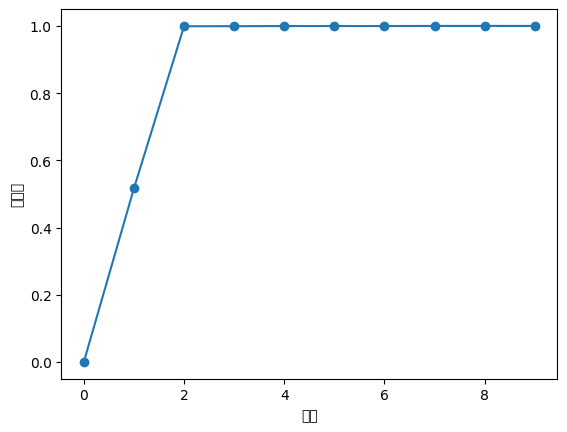

In [4]:
# coding: utf-8
import sys
sys.path.append('..')
sys.path.append('../ch07')
import numpy as np
import matplotlib.pyplot as plt
from data_set import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from CH7.seq2seq import Seq2seq
# from CH7.peeky_seq2seq import PeekySeq2seq


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

#### 8.3.3 어텐션 시각화

- 어텐션이 시계열 변환을 수행할 때, 어느 원소에 주의를 기울이는지를 눈으로 살펴보려는 시도이다.
- Attention 계층은 각 시각의 어텐션 가중치를 인스턴스 변수로 보관하고 있으므로, 이를 시각화하는 것은 간단하다.
- 가중치 자체가 어떤 데이터에 집중하고 있는지를 나타내기 때문이다.
- 

<img width="672" alt="fig 8-27" src="https://github.com/choibigo/Study/assets/38881179/6f0d4bfb-b275-4d3a-b37d-16bc8bea9673">

- FRIDAY 문자들은 입력데이터에 아무 것에도 집중하지 않는다.
- AUGUST는 입력데이터의 월에 26은 일, 1983은 년도에 대해 집중하고 있다.

<img width="664" alt="fig 8-28" src="https://github.com/choibigo/Study/assets/38881179/8eaeb111-4834-401f-8aef-1bef92454038">
